# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras , os , tqdm , cv2
from keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , BatchNormalization , Dropout , Flatten
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load Data

In [7]:
trainDir = r'C:\Users\GAURAV DEV\Music\Unified Mentor Projects\ASL_detection\dataset\asl_alphabet_train\asl_alphabet_train'
testDir = r'C:\Users\GAURAV DEV\Music\Unified Mentor Projects\ASL_detection\dataset\asl_alphabet_test\asl_alphabet_test'

In [8]:
def loadTrsinData (trainDir , imageWidth , imageHight) :
  classes = os.listdir(trainDir)
  imagesList = []
  labels = []
  for clas in tqdm.tqdm(classes) :
    classesPath = os.path.join(trainDir,clas)
    for image in os.listdir(classesPath) :
      imgPath = os.path.join(trainDir,clas,image)
      img = cv2.imread(imgPath)
      img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img , (imageWidth , imageHight))
      imagesList.append(img)
      labels.append(clas)

  return imagesList , labels

# Explore Data 

In [9]:
def displaySampleOfData (trainDir , imageWidth , imageHight) :
  plt.figure(figsize=(10,15))
  classes = os.listdir(trainDir)
  for i,clas in tqdm.tqdm(enumerate(classes)):
    plt.subplot(6,5,i+1)
    classesPath = os.path.join(trainDir,clas)
    image = os.listdir(classesPath)[0]
    image = os.path.join(trainDir,clas,image)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img , (imageWidth , imageHight))
    plt.title(clas)
    plt.imshow(img , cmap='gray')
  plt.show()

29it [00:00, 35.71it/s]


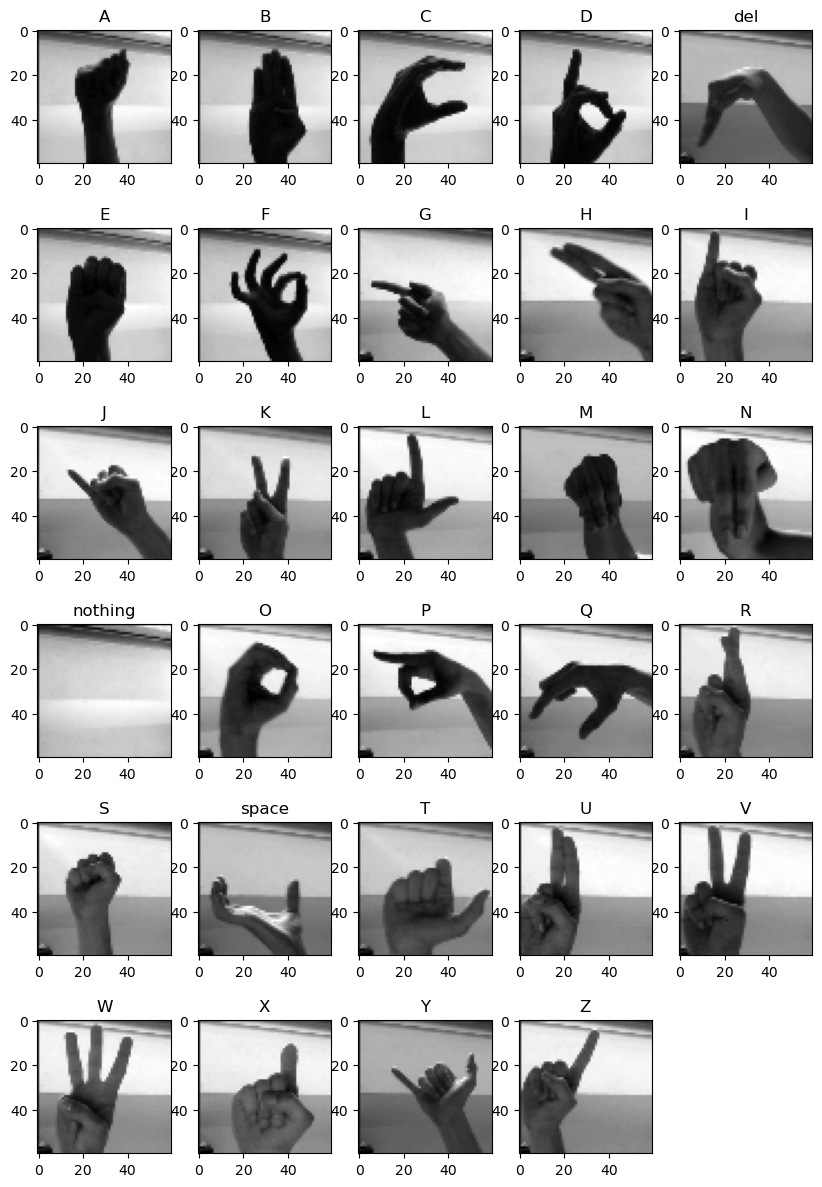

In [10]:
displaySampleOfData(trainDir ,60 ,60 )

In [11]:
# load data after explore the images and study it's case
X , y = loadTrsinData(trainDir , 60 , 60)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [10:36<00:00, 21.94s/it]


In [12]:
testImages = []
testLabels = []
for img in tqdm.tqdm(os.listdir(testDir)):
  trainImagePath = os.path.join(testDir , img)
  image = cv2.imread(trainImagePath)
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image,(60,60))
  testImages.append(image)
  testLabels.append(img)

100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 141.43it/s]


# Data PreProcessing

train

In [13]:
# shuffles x and y to make better training
XShuffled , yShuffled = shuffle(X,y,random_state=42)

In [14]:
# convert list to np array
xtrain = np.array(XShuffled)
ytrain = np.array(yShuffled)

In [15]:
# shape of xtrain
xtrain.shape

(87000, 60, 60)

In [16]:
# Scale the train data
xtrain = xtrain.astype('float32') / 255.0

In [17]:
# Reshape xtrain to fit conv network
xtrainReshaped = xtrain.reshape( (87000, 60, 60 , 1) )

In [18]:
xtrainReshaped.shape

(87000, 60, 60, 1)

In [19]:
# Create list of classes and dic to convert y labels to numbers
cats = [i for i in os.listdir(trainDir)]
categories = {}
for i,c in enumerate(cats) :
  categories[c] = i

In [20]:
# convert labels in ytrain to numbers
for i in range (len(ytrain)) :
  ytrain[i] = categories[ytrain[i]]

ytrain

array(['19', '9', '11', ..., '25', '0', '5'], dtype='<U7')

In [21]:
# Convert ytrain from numpy array to categoricl formate to fit in the training
ytrain = to_categorical(ytrain)

test

In [22]:
testImages = np.array(testImages)
testLabels = np.array(testLabels)

In [23]:
testImages = testImages.astype('float32') / 255.0

In [24]:
testImages = testImages.reshape( (-1, 60, 60 , 1) )

In [25]:
for i in range(len(testLabels)) :
  testLabels[i] = testLabels[i].split('_')[0]

testLabels

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'nothing', 'N', 'O', 'P', 'Q', 'R', 'space', 'S', 'T', 'U', 'V',
       'W', 'X', 'Y', 'Z'], dtype='<U16')

In [26]:
testDic = {}
for i,c in enumerate(testLabels):
  testDic[c]=i

In [27]:
for i in range( len(testLabels) ):
  testLabels[i] = testDic[testLabels[i]]

In [28]:
testLabels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27'], dtype='<U16')

In [29]:
testLabels = to_categorical(testLabels , num_classes=29)

In [30]:
testImages = np.array(testImages, dtype=np.float32)
testLabels = np.array(testLabels, dtype=np.int32)

# Data Modeling

In [31]:
Model = Sequential ([
    Conv2D(128 , (3,3) , activation='relu' , input_shape =(60,60,1)),
    MaxPooling2D((2,2)),
    Conv2D(64 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Conv2D(32 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256 , activation='relu'),
    Dropout(0.2),
    Dense(128 , activation='relu'),
    Dropout(0.15),
    Dense(64 , activation='relu'),
    Dense(len(cats) , activation='softmax'),
])

In [32]:
Model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [33]:
Model.fit(xtrainReshaped , ytrain  , validation_split=0.2 , epochs = 10)

Epoch 1/10


2175/2175 [==============================] - 155s 71ms/step - loss: 1.2674 - accuracy: 0.5956 - val_loss: 0.3010 - val_accuracy: 0.9022
Epoch 2/10
2175/2175 [==============================] - 164s 75ms/step - loss: 0.3094 - accuracy: 0.8925 - val_loss: 0.1528 - val_accuracy: 0.9482
Epoch 3/10
2175/2175 [==============================] - 161s 74ms/step - loss: 0.1818 - accuracy: 0.9390 - val_loss: 0.1050 - val_accuracy: 0.9602
Epoch 4/10
2175/2175 [==============================] - 162s 74ms/step - loss: 0.1396 - accuracy: 0.9554 - val_loss: 0.0766 - val_accuracy: 0.9737
Epoch 5/10
2175/2175 [==============================] - 158s 73ms/step - loss: 0.1038 - accuracy: 0.9664 - val_loss: 0.0321 - val_accuracy: 0.9914
Epoch 6/10
2175/2175 [==============================] - 163s 75ms/step - loss: 0.0895 - accuracy: 0.9711 - val_loss: 0.0225 - val_accuracy: 0.9931
Epoch 7/10
2175/2175 [==============================] - 168s 77ms/step - loss: 0.0778 - accuracy: 0.9753 - val_loss:

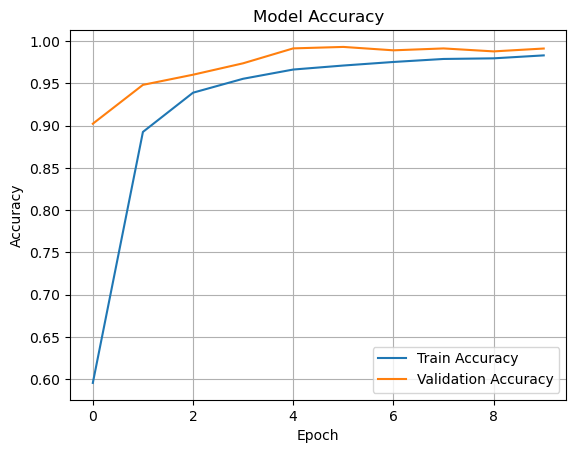

In [34]:
plt.plot(Model.history.history['accuracy'], label='Train Accuracy')
plt.plot(Model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()